# Игры — Формирование модели монетизации

### Дополнительные материалы исследования:
- [Презентация](https://drive.google.com/file/d/1J8o790XgSjbQNMYfntWuMzZLuADAeI7H/view?usp=sharing)
- [Дашборд](https://public.tableau.com/views/SpaceBrothers_16570606890240/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link)

### Описание проекта**:** 

Игровая механика «Космических братьев» основана на том, что пользователи строят свою космическую программу и пытаются преуспеть в колонизации галактики. Модель монетизации ещё не выстроена, но предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки. Стоимость рекламного показа - 0.07 USD.

**Цель исследования: Сформировать модель монетизации игрового приложения.**

Критерии успешной модели:
1. Пользователь лоялен и готов смотреть рекламу (реклама не спровоцирует отток).
2. Реклама имеет положительную окупаемость уже на первом уровне (в худшем случае - нулевую).

При этом, задача удержать пользователя и перевсти на 2-й уровень является более приоритетной, чем получение прибыли.

Также в рамках исследования необходимо проверить 2 статистические гипотезы.

### **Описание датасетов:**

В датасете представлены данные по игре пользователей на первом уровне. Завершение первого уровня требует от игрока выполнения одного из двух условий:

- Победа над первым врагом.
- Реализация проекта - разработка орбитальной сборки спутников.

В датасете содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно.

Датасет **game_actions.csv**:

- `event_datetime` — время события;
- `event` — одно из трёх событий:
    1. `building` — объект построен,
    2. `finished_stage_1` — первый уровень завершён,
    3. `project` — проект завершён;
- `building_type` — один из трёх типов здания:
    1. `assembly_shop` — сборочный цех,
    2. `spaceport` — космопорт,
    3. `research_center` — исследовательский центр;
- `user_id` — идентификатор пользователя;
- `project_type` — тип реализованного проекта;

Датасет **ad_cost.csv**:

- `day` - день, в который был совершен клик по объявлению
- `source` - источник трафика
- `cost` - стоимость кликов

Датасет **user_source.csv**:

- `user_id` - идентификатор пользователя
- `source` - источников, с которого пришёл пользователь, установивший приложение

-------------

## Предобработка данных

Для начала импортируем все библиотеки, с которыми будем работать.

In [1]:
import os
import pandas as pd
import numpy as np

from collections import Counter as c
from datetime import datetime, timedelta
from time import monotonic

import matplotlib.pyplot as plt 
import seaborn as sns

from scipy import stats as st

import warnings
warnings.filterwarnings('ignore')

Импортируем данные.

In [2]:
if os.path.exists ('ad_costs.csv'):
    ad_costs = pd.read_csv('ad_costs.csv')
else:
    ad_costs = pd.read_csv('/datasets/ad_costs.csv') 

if os.path.exists ('game_actions.csv'):
    game_actions = pd.read_csv('game_actions.csv')
else:
    game_actions = pd.read_csv('/datasets/game_actions.csv') 

if os.path.exists ('user_source.csv'):
    user_source = pd.read_csv('user_source.csv')
else:
    user_source = pd.read_csv('/datasets/user_source.csv') 

Напишем функцию, чтобы получить первичное представление о данных.

In [3]:
def df_info (df):
    
    print(df.columns)
    print()
    print(df.info(memory_usage='deep'))
    display(df.sample(5))
    print('Количество пропущенных значений:')
    print(df.isna().sum())
    print()
    print('Количество дубликатов:', df.duplicated().sum())
    
    return

**ad_costs**

In [4]:
df_info(ad_costs)

Index(['source', 'day', 'cost'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 4.2 KB
None


,source,day,cost
2,facebook_ads,2020-05-05,260.185754
7,instagram_new_adverts,2020-05-03,943.204717
22,youtube_channel_reklama,2020-05-04,259.073224
26,youtube_channel_reklama,2020-05-08,40.217907
23,youtube_channel_reklama,2020-05-05,147.041741


Количество пропущенных значений:
source    0
day       0
cost      0
dtype: int64

Количество дубликатов: 0


Видим, что у нас неверно определён тип данных `day`. Приведём его к соответствующему формату.

In [5]:
ad_costs['day'] = pd.to_datetime(ad_costs['day'], format = '%Y-%m-%d')

Изучим приведённые в порядок данные с помощью describe().

In [6]:
ad_costs.describe(include='all').round(2).T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
source,28,4,yandex_direct,7,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day,28,7,2020-05-05 00:00:00,4,2020-05-03,2020-05-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cost,28.0,NaN,NaN,NaN,NaT,NaT,271.56,286.87,23.31,66.75,160.06,349.03,969.14


Также рассмотрим, какие у нас есть уникальные источники, и как они распределены.

In [7]:
c(ad_costs['source'])

Counter({'facebook_ads': 7,
         'instagram_new_adverts': 7,
         'yandex_direct': 7,
         'youtube_channel_reklama': 7})

**Выводы:**

1. Видим, что таблица содержит данные о пользователях, пришедших с 3 мая по 9 мая включительно.
2. У нас есть 4 рекламных источника, которые содержат информацию по тратам за каждый из дней.
3. Медианная стоимость привлечения в день - 160.

**game_actions**

In [8]:
df_info(game_actions)

Index(['event_datetime', 'event', 'building_type', 'user_id', 'project_type'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 43.1 MB
None


,event_datetime,event,building_type,user_id,project_type
81635,2020-05-11 09:27:15,building,spaceport,4f51d206-3f7b-4aff-b38d-a7083c9b53b0,NaN
119165,2020-05-16 19:30:10,building,spaceport,a1d79fad-a8cd-4587-aad0-d167a40d84f8,NaN
129120,2020-05-19 23:48:28,finished_stage_1,NaN,23afd857-c3d8-442b-9d7f-f95e5e3ba65e,NaN
70480,2020-05-10 11:57:05,building,assembly_shop,ae575ff3-4225-4f09-8cee-7fcaa8120cf0,NaN
34946,2020-05-07 17:23:23,building,assembly_shop,3d0f886c-e6e6-4ed0-8964-776b6faec438,NaN


Количество пропущенных значений:
event_datetime         0
event                  0
building_type       7683
user_id                0
project_type      133774
dtype: int64

Количество дубликатов: 1


Видим, что у нас есть пропущенные значения в building_type и project_type (связанные, вероятно, с тем, что они не связаны с соответствующими ивентами). Заполнять эти значения не имеет смысла. Исправим незначительные ошибки в данных.

Приведём неверный формат `event_datetime` к datetime.

In [9]:
game_actions['event_datetime'] = pd.to_datetime(game_actions['event_datetime'], format = '%Y-%m-%d %H:%M:%S')

Удалим имеющийся единственный дубликат.

In [10]:
game_actions = game_actions.drop_duplicates().reset_index(drop=True)

Изучим приведённые в порядок данные с помощью describe().

In [11]:
game_actions.describe(include='all').round(2).T

,count,unique,top,freq,first,last
event_datetime,135639,128790,2020-05-10 03:08:18,4,2020-05-04 00:00:01,2020-06-05 12:32:49
event,135639,3,building,127956,NaT,NaT
building_type,127956,3,spaceport,59325,NaT,NaT
user_id,135639,13576,d6aca06a-cd75-4cd8-b8cd-240a3c163884,22,NaT,NaT
project_type,1866,1,satellite_orbital_assembly,1866,NaT,NaT


Видим, что у нас всего 1 вид project_type. Проверим, насколько он соотносится с событием project. И насколько событие project соотносится с событием finished_stage_1.

In [12]:
game_actions.groupby('event')['user_id'].nunique()

event
building            13576
finished_stage_1     5817
project              1866
Name: user_id, dtype: int64

In [13]:
(
    game_actions
    .query('event in ["project", "finished_stage_1"]')
    .groupby('user_id')['event'].nunique()
    .reset_index()
    .query('event == 2').count()
)

user_id    1866
event      1866
dtype: int64

**Выводы:**

1. Таблица содержит данные о событиях пользователей с 4 мая по 5 июля включительно. Что примечательно: привлечение пользователя началось с 3 мая, т.к. закупка рекламы происходит за день до показа рекламы. 
2. Наиболее популярным событием является building. Около 50% пользователей строят spaceport.
3. Видим, что строительтсво объектов является обязательным условием для завершения 1-го уровня.
4. Около 30% успешно завершают проект. Вероятно, остальные 70% пользователей выбирают сразиться с врагом.
5. satellite_orbital_assembly является единственным доступным проектом на 1-м уровне.

**user_source**

In [14]:
df_info(user_source)

Index(['user_id', 'source'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 2.2 MB
None


,user_id,source
12322,e852fc6d-2096-4382-898e-dcd7567a5f27,yandex_direct
6801,7e5e083e-402c-4d43-a7cd-e8a1155c3897,youtube_channel_reklama
13472,fe00942f-ec13-4642-93f4-8f5cdb0d2c75,yandex_direct
10446,c5220342-efb4-401a-83e0-87535307024f,yandex_direct
11956,e1827bd1-a9c1-4790-9e54-32058d5d69e1,yandex_direct


Количество пропущенных значений:
user_id    0
source     0
dtype: int64

Количество дубликатов: 0


In [15]:
c(user_source['source'])

Counter({'facebook_ads': 2726,
         'yandex_direct': 4817,
         'youtube_channel_reklama': 2686,
         'instagram_new_adverts': 3347})

In [16]:
user_source.describe(include='all').round(2).T

,count,unique,top,freq
user_id,13576,13576,ffa7e2c4-e05a-40d5-b66a-4c62d032575d,1
source,13576,4,yandex_direct,4817


**Выводы:**

1. Чистые данные без аномалий.
2. Наиболее частым рекламным источником для пользователей является yandex_direct.

---------------

## Исследовательский анализ данных

Построим гистограмму для событий, чтобы посмотреть активность пользователей за месяц.

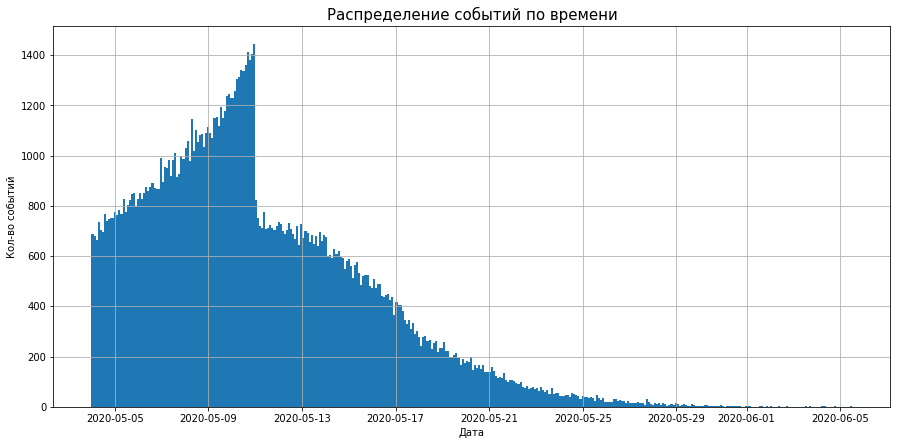

In [17]:
#чтобы вычислить оптимальное кол-во интервалов для bins, извлечём из кол-ва значений квадратный корень

b = int(game_actions['event_datetime'].shape[0]**0.5)

game_actions['event_datetime'].hist(bins=b, figsize=(15, 7))

plt.title('Распределение событий по времени', fontsize=15)
plt.xlabel('Дата')
plt.ylabel('Кол-во событий')

plt.show()

Видим, что у нас резкое увеличение событий примерно до 11 мая, после чего резко отрезается до половины и после этого медленно падает. Необходимо исследовать даннную аномалию. 

Посмотрим внимательнее, кто из этих пользователей завершил уровень, а кто - нет. Добавим новый атрибут `finished`, в который пропишем категорию пользователя согласно его `user_id` и тому, каким образом он завершил/не завершил уровень. Это упростит дальнейшую работу с данными.

- `unfinished` - не закончил уровень;
- `project` - закончил через проект;
- `battle` - закончил через бой с противником.

Для начала отфильтруем всех тех, кто закончил уровень.

In [18]:
id_fin = (
    game_actions.
    loc[(game_actions['event'] == 'finished_stage_1') | (game_actions['event'] == 'project'), ['user_id', 'project_type']]
    .drop_duplicates().reset_index(drop=True)
)

Теперь выберем из них тех, кто закончил проект и создадим отдельно датафрейм, в который запишем категорию пользователя, а также список из `user_id`, чтобы затем по нему фильтровать первую таблицу.

In [19]:
id_fin_pr = id_fin.groupby('user_id').agg({'project_type': 'nunique'}).query('project_type == 1').reset_index()
id_fin_pr['finished'] = 'project'
id_fin_pr_list = id_fin_pr['user_id']

Уберём из таблицы тех, кто закончил уровень проектом. Добавим им категорию `battle`, а затем присоединим один датафрейм к другому.

In [20]:
id_fin = id_fin.query('user_id not in @id_fin_pr_list').reset_index(drop=True)
id_fin['finished'] = 'battle'
id_fin = pd.concat([id_fin, id_fin_pr], axis=0)

Склеим изначальную таблицу с фильтрованной по uid. Там, где у нас пропущенные значения в новом атрибуте `finished` - проставим `unfinished`.

In [21]:
game_actions = game_actions.merge(id_fin[['user_id', 'finished']], on='user_id', how='left')
game_actions['finished'] = game_actions['finished'].fillna('unfinished')
game_actions.head()

,event_datetime,event,building_type,user_id,project_type,finished
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,unfinished
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,project
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,battle
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN,unfinished
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN,battle


Проверим корректность.

In [22]:
game_actions.query('user_id == "c07b1c10-f477-44dc-81dc-ec82254b1347"')

,event_datetime,event,building_type,user_id,project_type,finished
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,project
27085,2020-05-06 23:49:25,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,project
28866,2020-05-07 03:56:30,building,spaceport,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,project
30712,2020-05-07 07:58:20,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,project
30946,2020-05-07 08:30:13,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,project
55068,2020-05-09 09:30:40,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,project
64546,2020-05-10 02:18:34,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,project
86328,2020-05-11 23:16:25,building,research_center,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,project
88074,2020-05-12 04:26:44,building,research_center,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,project
96372,2020-05-13 05:45:37,building,spaceport,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,project


Видим, что у нас сначала завершился проект, потом на следующий день достроилось здание, а ещё на следующий - произошёл переход на новый уровень. ВОзможно, пользователь не может перейти на следующий уровень до того, как у него всё не достроится на первом (автоматический трекинг события), и пока он не подтвердит, что строительство завершено и он переходит. Иначе непонятен такой разрыв в днях. 

Посмотрим, какое у нас распределение закончивших/не закончивших уровень.

In [23]:
print(' % пользователей, заверших/не завершивших уровень в 1-й месяц:')

(
    game_actions
    .groupby('finished')['user_id'].nunique()
    .reset_index()
    .groupby('finished')
    .agg({'user_id': lambda x: x / game_actions['user_id'].nunique() * 100})
)

 % пользователей, заверших/не завершивших уровень в 1-й месяц:


,user_id
finished,
battle,29.102829
project,13.744844
unfinished,57.152328


In [24]:
print('% пользователей, заверших уровень в 1-й месяц:')
np.round(game_actions.query('event == "finished_stage_1"')['user_id'].nunique() / game_actions['user_id'].nunique() * 100, 2)

% пользователей, заверших уровень в 1-й месяц:


42.85

42.85% прохождения игры в первый месяц - довольно хороший результат, с учётом того, что остальные могут завершить уровень в следующий месяц. Построим гистограмму и сравним распределение событий в группах закончивших/не закончивших, чтобы выяснить, что провоцирует резкий спад событий 11 мая.

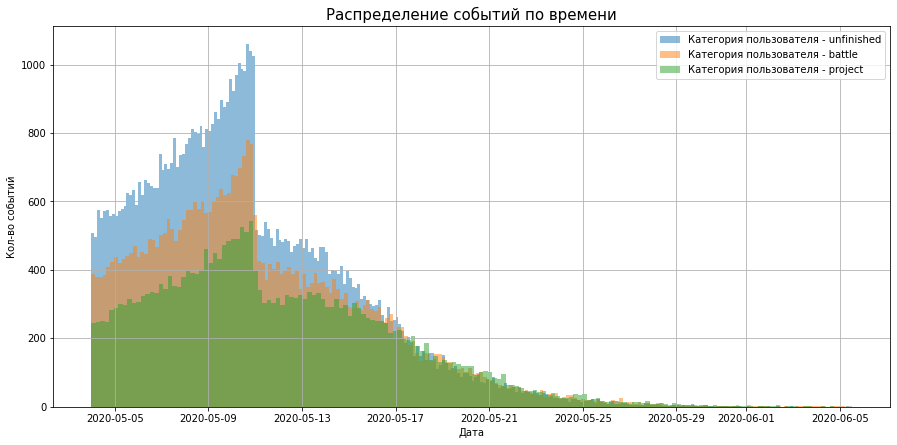

In [25]:
plt.figure(figsize = (15,7))

for var in ['unfinished', 'battle', 'project']:
    
    b = int(game_actions.query('finished == @var')['event_datetime'].shape[0]**0.5)
    
    game_actions.query('finished == @var')['event_datetime'].hist(label=f"Категория пользователя - {var}", bins=b, alpha=0.5)

plt.title('Распределение событий по времени', fontsize=15)
plt.xlabel('Дата')
plt.ylabel('Кол-во событий')
plt.legend()

plt.show()

Поведение пользователей, не закончивших уровень, абсолютрно идентично тем, кто его закончил. То есть, ввероятно, пользователи ещё дойдут до завершения уровня. Посмотрим теперь, когда именно пользователи заканчивают уровень.

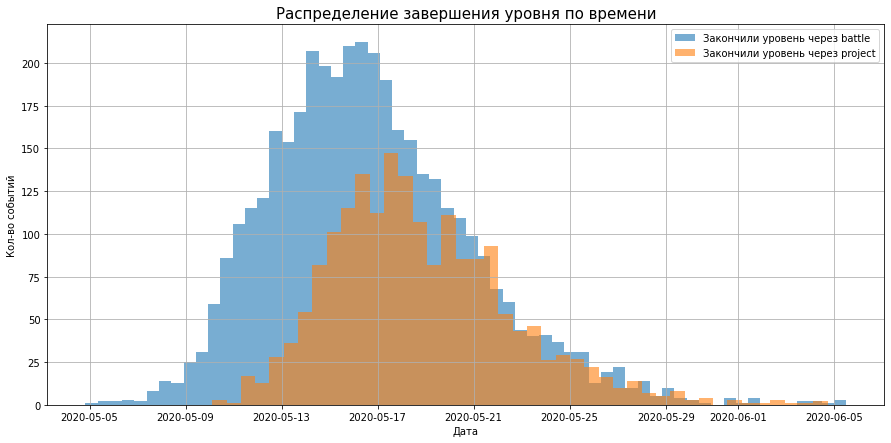

In [26]:
plt.figure(figsize = (15,7))

for var in ['battle', 'project']:

    b = int(game_actions.query('event == "finished_stage_1" & finished == @var')['event_datetime'].shape[0]**0.5)

    (
        game_actions
        .query('event == "finished_stage_1" & finished == @var')['event_datetime']
        .hist(label=f"Закончили уровень через {var}", bins=b, alpha=0.6)
    )

plt.title('Распределение завершения уровня по времени', fontsize=15)
plt.xlabel('Дата')
plt.ylabel('Кол-во событий')
plt.legend()
#plt.savefig('fin_hist.png')

plt.show()

Текущая гистограмма имеет более нормальное распредление. 

1. Видим, что большинство пользователей заканчивают уровень где-то 16 мая. 
2. Через battle уровень можно завершить раньше, чем через project. 
3. Ненормальное распределение провоцируют события building. Необходимо понять, какие именно.

Посмотрим на события в разбивке по типу пользователя.

In [27]:
game_actions['event_datetime_d'] = game_actions['event_datetime'].dt.date

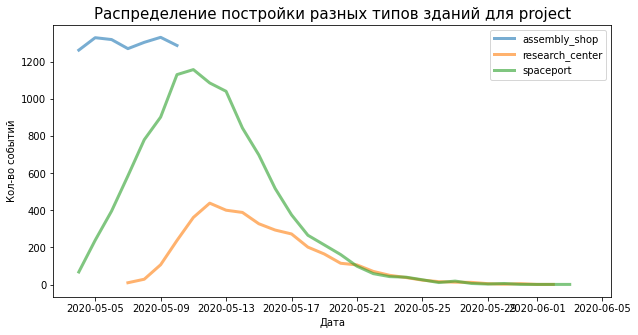

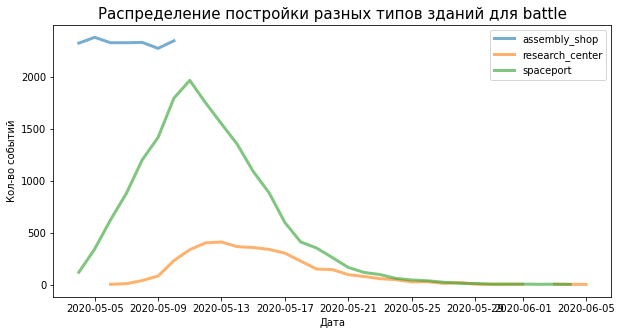

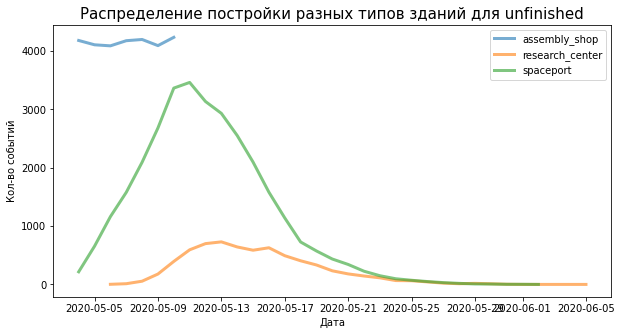

In [28]:
for ind in ['project', 'battle', 'unfinished']:
    
    (
        game_actions
        .query('finished == @ind')
        .pivot_table(index='event_datetime_d', columns='building_type', values='user_id', aggfunc='count')
        .plot(figsize=(10, 5), alpha=0.6, linewidth=3)
    )

    plt.title(f"Распределение постройки разных типов зданий для {ind}", fontsize=15)
    plt.xlabel('Дата')
    plt.ylabel('Кол-во событий')
    plt.legend()

    plt.show()

Видим для всех пользователей одинаковую картину распределения событий. Сначала они строят assembly_shop. Числа 11 строительство этого типа зданий резко прекращается. Кол-во построенных зданий всегда одинаково. Можно предположить, что строительство здания необходимо для постройки research_center, т.к. видим, что в самом начале пользователи не строят ни одного такого здания. Строительство этого типа происходит в первую неделю приобретения пользователей.

In [29]:
print('Первое событие строительство research_center:')
game_actions.query('building_type == "research_center"')['event_datetime'].min()

Первое событие строительство research_center:


Timestamp('2020-05-06 03:43:43')

Высчитаем timedelta между событиями, чтобы понять, сколько времени занимает их строительство. В таймдельту будем записывать время от 1-го события до следующего, поэтому таймдельта для 1-го события будет NaN. Следовательно часть таймдельты для assembly_shop мы потеряем из-за того, что это первое событие в приложении и первый тип здания, который может построить пользователь.

In [30]:
%%time

game_actions['timedelta'] = game_actions.groupby('user_id')['event_datetime'].diff()

CPU times: user 2.4 s, sys: 32 ms, total: 2.43 s
Wall time: 2.45 s


In [31]:
game_actions.query('user_id == "c07b1c10-f477-44dc-81dc-ec82254b1347"')

,event_datetime,event,building_type,user_id,project_type,finished,event_datetime_d,timedelta
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,project,2020-05-04,NaT
27085,2020-05-06 23:49:25,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,project,2020-05-06,2 days 23:49:22
28866,2020-05-07 03:56:30,building,spaceport,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,project,2020-05-07,0 days 04:07:05
30712,2020-05-07 07:58:20,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,project,2020-05-07,0 days 04:01:50
30946,2020-05-07 08:30:13,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,project,2020-05-07,0 days 00:31:53
55068,2020-05-09 09:30:40,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,project,2020-05-09,2 days 01:00:27
64546,2020-05-10 02:18:34,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,project,2020-05-10,0 days 16:47:54
86328,2020-05-11 23:16:25,building,research_center,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,project,2020-05-11,1 days 20:57:51
88074,2020-05-12 04:26:44,building,research_center,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,project,2020-05-12,0 days 05:10:19
96372,2020-05-13 05:45:37,building,spaceport,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,project,2020-05-13,1 days 01:18:53


Посмотрим на таймдельту в разбивке по зданиям.

In [32]:
game_actions.groupby('building_type')['timedelta'].describe(include='all').round(2).T

building_type,assembly_shop,research_center,spaceport
count,40918,14137,59325
mean,0 days 22:43:08.420743926,1 days 00:14:03.205276932,1 days 11:07:46.481854193
std,0 days 21:42:53.300465770,0 days 18:40:29.750351809,1 days 09:58:39.249225850
min,0 days 00:00:02,0 days 00:00:07,0 days 00:00:04
25%,0 days 06:44:27.250000,0 days 08:32:09,0 days 09:43:16
50%,0 days 16:05:17.500000,0 days 19:51:14,0 days 23:54:25
75%,1 days 07:55:46.750000,1 days 12:45:41,2 days 01:57:00
max,6 days 14:50:14,2 days 23:59:46,6 days 23:57:14


Видим, что у нас медиана между событиями в простройке зданий проходит где-то на 16-23 часах. То есть, вероятно, столько времени проходит между постройкой 2-х зданий. Каких точно, мы не можем сказать, т.к. логи записываются по порядку и постройка может инициироваться во время строительства ещё одного объекта. Тем не менее, мы можем заметить тренды:

1. Меньше всего времени занимает строительство assembly_shop (медиана - 16 ч). Затем идёт research_center(20 ч) и spaceport (24 ч).
2. Возможно, у assembly_shop самое минимальное время не потому, что оно действительно минимальное, а из-за того, что пользователи в процессе погружения в игру заходят в неё/строят максимально часто.
3. research_center - это событие, которое открывется последним, поэтому до его постройки у нас самое "минимальное максимальное" время - всего 3 дня. Вероятно, пользователи, которые его строят, уже наиболее вовлечены в игру и наименее будут подвержены оттоку. Или же, это происходит благодаря наложению финиша событий spaceport.
2. Видим, что хотя бы 1 р/день пользователи всё-таки заходят в приложение, что должно положительно влиять на retention.

Посчитаем среднее время, которое необходимо для прохождения игры, в днях.

In [33]:
fin_time = (
    game_actions
    .groupby(['user_id', 'finished'])
    .agg({'event_datetime': lambda x: x.max() - x.min()})
    .reset_index()
    .rename(columns={'event_datetime': 'timedelta'})
)

fin_time['timedelta_d'] = fin_time['timedelta'].astype('timedelta64[D]')

fin_time.head()

,user_id,finished,timedelta,timedelta_d
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,unfinished,14 days 10:18:29,14.0
1,00151b4f-ba38-44a8-a650-d7cf130a0105,unfinished,12 days 07:37:40,12.0
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,unfinished,8 days 15:12:35,8.0
3,001d39dc-366c-4021-9604-6a3b9ff01e25,battle,6 days 10:38:42,6.0
4,002f508f-67b6-479f-814b-b05f00d4e995,unfinished,16 days 12:56:47,16.0


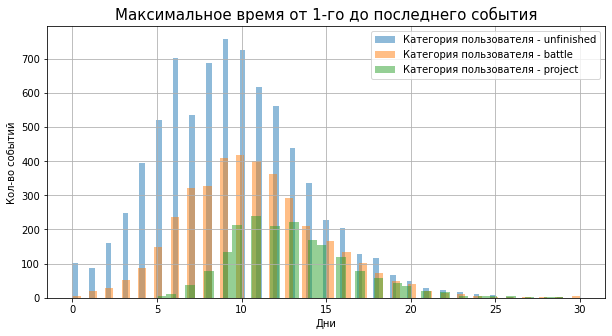

In [34]:
plt.figure(figsize = (10,5))

for var in ['unfinished', 'battle', 'project']:
    
    b = int(fin_time.query('finished == @var')['timedelta_d'].shape[0]**0.5)
    
    fin_time.query('finished == @var')['timedelta_d'].hist(label=f"Категория пользователя - {var}", bins=b, alpha=0.5)

plt.title('Максимальное время от 1-го до последнего события', fontsize=15)
plt.xlabel('Дни')
plt.ylabel('Кол-во событий')
plt.legend()

plt.show()

In [35]:
fin_time.groupby('finished')['timedelta'].describe(include='all').round(2).T

finished,battle,project,unfinished
count,3951,1866,7759
mean,11 days 02:30:24.076183244,13 days 11:00:49.135048231,9 days 18:54:58.255445289
std,4 days 02:17:54.287406787,3 days 12:11:01.977069676,4 days 08:16:01.522157579
min,0 days 09:39:01,5 days 03:22:27,0 days 00:00:00
25%,8 days 07:01:19.500000,10 days 22:49:58.750000,6 days 15:00:22.500000
50%,10 days 19:01:37,13 days 00:45:41,9 days 14:34:59
75%,13 days 10:33:17.500000,15 days 13:47:23.750000,12 days 11:14:57.500000
max,30 days 21:58:53,29 days 03:13:43,29 days 02:01:24


1. Видим, что пользователю требуются 1-2 недели на прохождение первого уровня. 
2. Путь через битву - быстрее, в среднем - 10 дней. Путь через проект - 13. Те, кто не заканчивают игру, в среднем, проводят в игре 9 дней. Возможно, они не успевают пройти первый уровень и теряют интерес. 
3. Пользователи, которые проходят игру через проект, проходят её дольше всего. Видим, что завершить уровень через battle можно в первый же день, для project минимальное кол-во дней - 5.

Посчитаем среднее и медиану событий по каждому типу пользователя.

In [36]:
(
    game_actions.
    groupby(['user_id', 'finished'])
    .agg({'event': 'count'})
    .reset_index().groupby('finished')
    .agg({'event': ['mean', 'median']})
)

event       
                 mean median
finished                    
battle      10.411541     11
project     14.647910     14
unfinished   8.657043      8

Медиана и среднее практически совпадают, что свидетельствует о малом разбросе и приближенному к нормальному распределениию.

In [37]:
(
    game_actions
    .groupby(['user_id', 'finished', 'building_type'])
    .agg({'event': 'count'})
    .reset_index()
    .groupby(['finished', 'building_type'])
    .agg({'event': ['mean', 'median']})
)

event       
                                mean median
finished   building_type                   
battle     assembly_shop    4.125032      4
           research_center  1.603330      1
           spaceport        4.399589      4
project    assembly_shop    4.885316      5
           research_center  1.981243      2
           spaceport        5.781350      6
unfinished assembly_shop    3.747906      4
           research_center  1.930407      2
           spaceport        4.203587      4

В целом, всё то же самое: не закончившие уровень игроки строят меньше, чем необходимо, для завершения уровня. При этом, если посмотрим на разбивку по типам зданий, то видим, что они строят чуть больше, чем те, кто завешил уровень, через battle, но меньше, чем те, кто завершил через проект. Тут можно предположить, что они выбирают своей основной стратегией "проект", но не могут его завершить. Хотя это предположение слабое и нуждается в более внимательном и детальном исследовании.

### Выводы:

Исходя из приведённого выше анализа, мы можем сделать следующие выводы и предположения:

1. События имеют неравномерное распределение.
2. Модель поведения у пользователей, которые завершили уровень через проект/битву или не завершили его, +/- одинаковая.
3. Самый быстрый путь перейти на новый уровень - через битву, медленный - через проект. В среднем, чтобы завершить 1-й уровень, требуются 1-2 недели.
4. Пользователи, не завершившие уровень, строят меньше построек, чем все остальные.
5. В среднем, строительство здания занимает около 12-24 ч. 
6. В среднем, пользователи заходят в приложение 1 р/день.

В связи с этим можно дать следующие рекомендации:

1. Возможно, стоит уменьшить время прохождения первого уровеня для большего вовлечения пользователей. Кажется, что 1-2 недели на 1-й уровень - это довольно много.
2. В связи с этим, стоит уменьшить время постройки внутри приложения. Потенциально, это не только увеличит переход на следующий уровень, но и увеличит retention. 

------------

## Расчёт модели монетизации

Сначала посмотрим, сколько вообще компания платит за привлечение пользователей.

In [38]:
print('Сумма затрат:', ad_costs['cost'].sum().round(2))


Сумма затрат: 7603.58


In [39]:
ad_costs.head()

,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


In [40]:
print('Сумма затрат в разбивке по каналам:')

ad_costs.groupby('source')['cost'].sum().round(2)

Сумма затрат в разбивке по каналам:


source
facebook_ads               2140.90
instagram_new_adverts      2161.44
yandex_direct              2233.11
youtube_channel_reklama    1068.12
Name: cost, dtype: float64

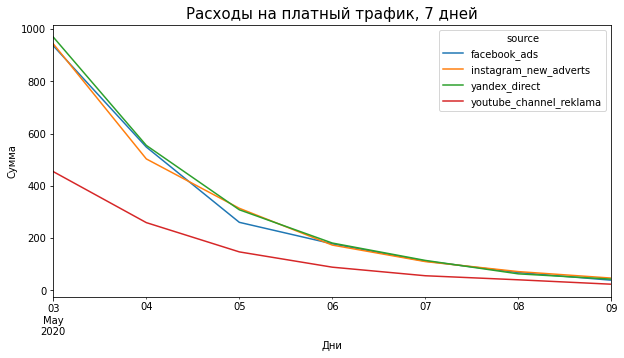

In [41]:
ad_costs.pivot_table(index='day', columns='source', values='cost').plot(figsize=(10, 5))

plt.title('Расходы на платный трафик, 7 дней', fontsize=15)
plt.xlabel('Дни')
plt.ylabel('Сумма')
plt.show()

Видим, что больше всего компания потратила на привлечение пользователей в первые дни. Посчитаем стоимость привлечения без разбивки по каналам, т.к. в данном иследовании у нас нет цели проанализировать прибыльность каналов и нужна универсальная модель.

In [42]:
#cpl = cost per lead
#cpi = cost per impression

costs = ad_costs['cost'].sum()
cpl = costs / game_actions['user_id'].nunique()
cpi = 0.07

print('Стоимость привлечения пользователя:', cpl.round(2))
print('Кол-во рекламных показов для окупаемости в 0:', (cpl / cpi).round(2))

Стоимость привлечения пользователя: 0.56
Кол-во рекламных показов для окупаемости в 0: 8.0


Точка безубыточности - 8 рекламных показов (или 0.56 USD). Для того, чтобы пользователь окупился, необходимо показать ему рекламу 9+ раз. Из проведённого ранее анализа, мы знаем, что пользователи строят от 8 до 14 построек, поэтому даже те пользователи, которые не завершают 1-й уровень в 1-й месяц, в итоге всё равно окупаются.

Посчитаем, сколько потенциально пользователь может принести компании прибыли. Расчитывать будем по следующей формуле:

**Выручка** = кол-во ивентов * стоимость рекламного показа

**ROMI (Return On Marketing Investment)** = (выручка - издержки) / издержки

Мы считаем по всей выборке (с выбросами и пр.), т.к. считаем, что именно в таком виде она будет являться максимально репрезентативной даже для последующих месяцев, если игровая механика не изменится.

In [43]:
revenue_ev = game_actions.query('event == "building"')['event'].count() * cpi

print('Потенциальная прибыль:', (revenue_ev - costs).round(2))
print('Потенциальный ROMI:',  f"{(revenue_ev) / costs: .2%}")

Потенциальная прибыль: 1353.34
Потенциальный ROMI:  117.80%


Видим, что ROMI - 117.80%, который свидетельствует о том, что на 1 вложенный доллар мы получили бы 1.17. Посчитаем также недополученную прибыль - реклама, которую можно было бы показывать после завершения проекта или уровня.

In [44]:
revenue_pr = game_actions.query('event == "project"')['event'].count() * cpi
revenue_fin = game_actions.query('event == "finished_stage_1"')['event'].count() * cpi

print('Потенциальная выручка project:', revenue_pr.round(2))
print('Потенциальная выручка finished_stage_1:', revenue_fin.round(2))
print('Максимальная потенциальная прибыль:', (revenue_ev + revenue_pr + revenue_fin - costs).round(2))
print('Максимальный потенциальный ROMI:', f"{(revenue_ev + revenue_pr + revenue_fin) / costs: .2%}")

Потенциальная выручка project: 130.62
Потенциальная выручка finished_stage_1: 407.19
Максимальная потенциальная прибыль: 1891.15
Максимальный потенциальный ROMI:  124.87%


Видим, что мы могли бы получить ещё 540 USD, если бы показывали рекламу после завершения проекта и уровня. Таким образом, окупаемость вышла бы 25%. Посчитаем отдельно окупаемость для finished_stage_1.

In [45]:
print('Потенциальный ROMI + finished_stage_1:', f"{(revenue_ev + revenue_fin) / costs: .2%}")

Потенциальный ROMI + finished_stage_1:  123.15%


### Выводы:

Мы проанализировали предложенную модель монетизации и сделали следующие выводы:

1. Чтобы пользователь окупался, ему нужно показывать рекламу от 9 раз (точка безубыточности = 8 рекламных показов). В среднем,пользователи строят здания 8-14 раз за 1-й уровень, поэтому предложенная PM модель монетизации будет окупаться и приносить примерно 18% прибыли от вложенных средств.


2. Тем не менее, существует способ повысить прибыль, показывая рекламу ещё и по завершении проекта/уровня. Т.к. после завершения проекта может сразу же последовать завершение уровня (если событтия не разорвутся постройкой здания), предлагаем показывать рекламу только после завершения уровня. В этот момент пользователь максимально замотивирован, чтобы продолжить игру дальше, и отток минимален. Такая модель поможет получить дополнительно +5% к окупаемости.


3. Стоит также отметить, что предложенная модель монетизации (building + finished_stage_1) будет оптимальной только с учётом текущей игровой механики. Сейчас время между постройками зданий занимает около 12-24 часов. При такой длительной постройке, мы показываем пользователю рекламу не больше 1-2 раз в сутки, что кажется адекватным. Тем не менее, такие долгие промежутки между событиями кажутся избыточными и могут приводить к тому, что пользователь не может пройти уровень и теряет интерес. Точно сказать об этом мы не можем из-за недостатка данных. В случае, если мы ускорим время постройки зданий и (соответственно) время прохождения пользователем уровня, мы можем увеличить удержание. В то же самое время реклама может стать для пользователя навязчивой и ещё больше провоцировать отток. 


**Альтернативная модель монетизации:**

Модель монетизации, исходящую из цели перевести пользователя на следующий уровень, можно сформулировать следующим образом:

1. Сократить время на прохождение 1-го уровня в 2 раза, чтобы посмотреть и проанализировать поведение пользователей. Наша задача, довести пользователей до завершения 1-го уровня в 1-ую неделю игры. 


2. Мы знаем, что, в среднем, пользователи завершают уровень за 1-2 недели и строят 11-14 зданий (1-2 показа рекламного объявления/день). Если мы сокращаем время на прохождение уровня в 2 раза, то нам надо пропорционально уменьшить кол-во показываемой рекламы.


3. В связи с этим рекомедуется плавно увеличивать кол-во показываемой рекламы. Например, на 1-м уровне, мы будем показывать рекламу на каждом 3-м построенном здании. На 2-м уровне, на каждом 2-м построенном здании, а начиная с 3-4 - на каждом.


4. Предложенную модель можно раскатить сначала только на небольшой процент пользователей приложения - 10-20%, а потом снять статистику по метрикам удержания. Если мы заметим улучшение поведенческих характеристик - масштабировать изменения на всю игровую логику приложения, а если ухудшатся - откатить обратно. 10-20% должны дать незначительный урон по окупаемости в случае негативного сценария и, вероятнее всего, окупятся с учётом LTV пользователя.


5. Сейчас невозможно точно сказать, насколько предложенная альтернативная модель будет окупаться, т.к. у нас нет данных об удержании и лайфтайме пользователя.

----------

## Проверка гипотез

Приступим к проверке статистических гипотез.

### Гипотеза 1:

**H_0:** Нет статистически значимых различий в среднем времени прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком.

**H_1:** Есть статистически значимые различия в среднем времени прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком.
    
В качестве $\alpha$ возьмём стандартное значение $\ 0.05$. 

Чтобы корректно посчитать среднее время прохождения, переведём таймдельту от первого до последнего посещения в секунды (т.к. это минимальное время, которое мы знаем).

In [46]:
fin_time['timedelta_s'] = fin_time['timedelta'].astype('timedelta64[s]')

fin_time.head()

,user_id,finished,timedelta,timedelta_d,timedelta_s
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,unfinished,14 days 10:18:29,14.0,1246709.0
1,00151b4f-ba38-44a8-a650-d7cf130a0105,unfinished,12 days 07:37:40,12.0,1064260.0
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,unfinished,8 days 15:12:35,8.0,745955.0
3,001d39dc-366c-4021-9604-6a3b9ff01e25,battle,6 days 10:38:42,6.0,556722.0
4,002f508f-67b6-479f-814b-b05f00d4e995,unfinished,16 days 12:56:47,16.0,1429007.0


Используем тест Шапиро-Уилка, чтобы понять, какой тест использовать для проверки гипотезы.

In [47]:
fin_type = ['project', 'battle']

for var in fin_type:   
        
    print(f"Проверка распределения для выборки {var}:")

    alpha = 0.05 

    results = st.shapiro(fin_time.query('finished == @var')['timedelta_s'])
    p_value = results[1]

    print(f"p-значение: {p_value: .5f}")

    if p_value < alpha:
        print('Отвергаем H_0: распределение не нормально')
    else:
        print('Не получилось отвергнуть H_0, распределение нормальное')
            
    print()


Проверка распределения для выборки project:
p-значение:  0.00000
Отвергаем H_0: распределение не нормально

Проверка распределения для выборки battle:
p-значение:  0.00000
Отвергаем H_0: распределение не нормально



Т.к. распределение ненормальное, будем использовать тест Манна-Уитни.

In [48]:
alpha = .05

results = st.mannwhitneyu(
    fin_time.query('finished == "project"')['timedelta_s'],
    fin_time.query('finished == "battle"')['timedelta_s']
)

print(f"p-значение: {results.pvalue: .5f}")

if (results.pvalue < alpha):
    print('Отвергаем H_0: есть статистически значимые различия в среднем времени прохождения уровня')
else:
    print('Не получилось отвергнуть H_0: нет статистически значимых различий в среднем времени прохождения уровня')

p-значение:  0.00000
Отвергаем H_0: есть статистически значимые различия в среднем времени прохождения уровня


### Гипотеза 2:

**H_0:** Нет статистически значимых различий в среднем количестве построек разного типа между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком.
    
**H_1:**  Есть статистически значимые различия в среднем количестве построек разного типа между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком.
    
В качестве  $\alpha = 0.05$ . Разделим выборки и посчитаем распределение на нормальность.

In [49]:
fin_event = (
    game_actions
    .query('event == "building" & finished != "unfinished"')
    .groupby(['user_id', 'finished', 'building_type'])['event']
    .count()
    .reset_index()
)

fin_event.head()

,user_id,finished,building_type,event
0,001d39dc-366c-4021-9604-6a3b9ff01e25,battle,assembly_shop,4
1,001d39dc-366c-4021-9604-6a3b9ff01e25,battle,spaceport,4
2,003ee7e8-6356-4286-a715-62f22a18d2a1,battle,assembly_shop,4
3,003ee7e8-6356-4286-a715-62f22a18d2a1,battle,research_center,1
4,003ee7e8-6356-4286-a715-62f22a18d2a1,battle,spaceport,3


In [50]:
#добавим ещё 1 параметр для цикла, объявляем в начале функции, чтобы было легче читать код

fin_type = ['project', 'battle']
build_type = ['assembly_shop', 'spaceport', 'research_center']

def shapiro (df):
    
    for var in fin_type:
        
        for ind in build_type:
            
            print(f"Проверка распределения для выборки {var}, постройка {ind}:")

            alpha = 0.05 

            results = st.shapiro(df.query('finished == @var & building_type == @ind')['event'])
            p_value = results[1]

            print(f"p-значение: {p_value: .5f}")

            if p_value < alpha:
                print('Отвергаем H_0: распределение не нормально')
            else:
                print('Не получилось отвергнуть H_0, распределение нормальное')
                
            print()
        
    return

In [51]:
shapiro(fin_event)

Проверка распределения для выборки project, постройка assembly_shop:
p-значение:  0.00000
Отвергаем H_0: распределение не нормально

Проверка распределения для выборки project, постройка spaceport:
p-значение:  0.00000
Отвергаем H_0: распределение не нормально

Проверка распределения для выборки project, постройка research_center:
p-значение:  0.00000
Отвергаем H_0: распределение не нормально

Проверка распределения для выборки battle, постройка assembly_shop:
p-значение:  0.00000
Отвергаем H_0: распределение не нормально

Проверка распределения для выборки battle, постройка spaceport:
p-значение:  0.00000
Отвергаем H_0: распределение не нормально

Проверка распределения для выборки battle, постройка research_center:
p-значение:  0.00000
Отвергаем H_0: распределение не нормально



Проверяем гипотезу с помощью Манна-Уитни с поправкой на множественные сравнения Бонферрони (т.к. у нас 3 события). Таким образом, $\alpha = 0.05/3$

In [52]:
build_type = ['assembly_shop', 'spaceport', 'research_center']

def mannwhitheyu (df, fin_type_1, fin_type_2, coef=1):
    
    for var in build_type:   
        
        print(f"Выборки {fin_type_1} и {fin_type_2}. Проверка для постройки {var}:")

        alpha = 0.05 / coef

        results = st.mannwhitneyu(
            df.query('finished == @fin_type_1 & building_type == @var')['event'],
            df.query('finished == @fin_type_2 & building_type == @var')['event']
        )
        

        print(f"p-значение: {results.pvalue: .5f}")

        if results.pvalue < alpha:
            print('Отвергаем H_0: есть статистически значимые различия в среднем кол-ве построек разного типа')
        else:
            print('Не получилось отвергнуть H_0: нет статистически значимых различий в среднем кол-ве построек разного типа')
            
        print()
        
    return

In [53]:
mannwhitheyu (fin_event, 'battle', 'project', 3)

Выборки battle и project. Проверка для постройки assembly_shop:
p-значение:  0.00000
Отвергаем H_0: есть статистически значимые различия в среднем кол-ве построек разного типа

Выборки battle и project. Проверка для постройки spaceport:
p-значение:  0.00000
Отвергаем H_0: есть статистически значимые различия в среднем кол-ве построек разного типа

Выборки battle и project. Проверка для постройки research_center:
p-значение:  0.00000
Отвергаем H_0: есть статистически значимые различия в среднем кол-ве построек разного типа



### Выводы:

Проверка гипотез показада различие в поведении пользователей, заканчивающих уровень через битву и через проект. У этих пользователей разное время, за которое они заканчивают уровень, и разное количество построек (разных типов). Возможно, в будущем, этих пользователей стоит рассмотреть внимательнее, на предмет того, какие из них показывают большее удержание и большую прибыль (с учётом LTV) и скорректировать игровую механику/модель монетизации. В текущем исследовании эти вопросы рассмотреть невозможно, т.к. недостаточно данных.

-----------------

## Выводы и рекомендации

В ходе исследования мы провели базовую предобработку данных, исправили найденные ошибки, категоризировали пользователей, разбив по типу завершения уровня (project | battle | unfinished), рассчитали таймдельту между событиями  и провели EDA.

**Поведенческие паттерны:**

Гистограммы подсветили, что пользователи всех 3-х категорий показывают схожее поведение при прохождении первого уровня, но есть и различия. Были замечены следующие поведенческие паттерны:

1. Самый быстрый путь перейти на новый уровень - через битву (можно завершить в тот же день), медленный - через проект (не менее 5 дней). В среднем, чтобы завершить 1-й уровень, требуются 1-2 недели.
4. Пользователи, не завершившие уровень, строят меньше построек, чем все остальные. В срденем - 8 построек (против 11 - битва и 14 - проект)
5. Строительство постройки занимает около 12-24 ч, что кажется избыточным и может негативно влиять на прохождение 1-го уровня и удержание.
6. В среднем, пользователи заходят в приложение 1 р/день.

Мы проанализировали распределение на нормальность с помощью Шапиро-Уилка (ненормальное) и проверили гипотезы непараметрическим тестом Манна-Уитни. Тесты показали, что есть статистически значимые различия в среднем времени прохождения и в среднем количестве построек разных типов для людей, которые завершают уровень через проект и через битву. 

**Модель монетизации:**

Мы рассчитали точку безубыточности - 0.56 USD (= стоимость привлечения пользователя) и выяснили, что для того, чтобы в неё попасть, необходимо показать 1 пользователю рекламу не менее 9 раз. Чтобы привлечение окупилось - 9+ раз. Т.к. среднее количество построек на пользователя больше 8 (ровно 8 для тех, кто не закончил уровень в 1-й месяц), предложенная PM модель должна окупаться и приносить примерно 18% прибыли от вкладываемых в рекламу средств. Окупаемость рекламных каналов мы не анализировали.

Помимо этого, мы предлагаем дополнительно монетизировать прохождение уровня, т.е. показывать пользователю рекламу, когда происходит finished_stage_n. Это позволит получить +5% к окупаемости. Также это довольно безопасно с точки зрения оттока, т.к. при переходе на следующий уровень пользователь максимально мотивирован, чтобы продолжить игру.

Можно рассмотреть вариант, когда мы дополнительно показываем рекламу пользователю каждые 30 мин (к примеру) непрерывного игрового времени. Но этот вопрос требует дополнительной проработки, текущих логов недостаточно. 

**На что следует обратить внимание:**

Предложенная модель монетизации будет оптимальной только с учётом текущей игровой механики. Сейчас время между постройками зданий занимает около 12-24 часов (1-2 рекламного показа в сутки, что кажется адекватным). Тем не менее, длительные промежутки между событиями кажутся избыточными и могут приводить к тому, что пользователь долго не может пройти уровень и теряет интерес. 

Зачастую первые уровни в играх делают достаточно лёгкими именно для того, чтобы пользователь мог сильнее втянуться игру. Возможно, стоит уменьшить время на строительство объектов и, тем самым, ускорить прохождение 1-го уровня до 7 дней. Но есть риск увеличить отток из-за навязчивой рекламы. 

В связи с этим рекомендуется плавно увеличивать кол-во показываемой рекламы. Например, на 1-м уровне, мы будем показывать рекламу на каждом 3-м построенном здании. На 2-м уровне, на каждом 2-м построенном здании, а начиная с 3-4 - на каждом.

Чтобы этого избежать, новую игровую логику можно раскать только на 10-20% пользователей. Если после изменений stickness и retention покажут улучшения в метриках (с учётом окупаемости), раскатать логику на остальных пользователей. В негативном сценарии, если мы спровоцируем отток, 10-20% должны дать небольшую просадку по удержанию и, вероятнее всего, окупятся с учётом LTV других пользователей.

Анализ более сложных моделей монетизации или поведенческих метрик было бы хорошо проводить на более полных данных. Например, учитывающих, когда пользователь входит в приложение и когда заканчивает сессию, какие ещё есть события в игре и др. 


---------------